In [1]:
import pandas as pd 

tr = 1 
preds_sf = f"./predictions/match_preds/t{tr}_euros2024.csv"

preds_df = pd.read_csv(preds_sf)
preds_df = preds_df.drop(["Unnamed: 1"], axis=1)
preds_df = preds_df.iloc[:36,]
preds_df["date"] = pd.to_datetime(preds_df["date"])


In [2]:
preds_df.head()

,stage,team_a,res_a,res_b,team_b,date
0,Group A,Germany,W,L,Scotland,2024-06-14
1,Group A,Hungary,L,W,Switzerland,2024-06-15
2,Group A,Germany,D,D,Hungary,2024-06-19
3,Group A,Scotland,L,W,Switzerland,2024-06-19
4,Group A,Switzerland,D,D,Germany,2024-06-23


In [3]:
import requests 
from bs4 import BeautifulSoup

results = "https://terrikon.com/en/euro-2024"
res_page = requests.get(results)
res_text = res_page.text 
res_soup = BeautifulSoup(res_text)

In [4]:
res_tbls = res_soup.find_all("table", class_="gameresult")
res_tbls = res_tbls[4:]

In [5]:
import io 

res_dfs = [pd.concat(pd.read_html(io.StringIO(table.prettify()))) for table in res_tbls]
# concat needed as without, each index was a list 

In [6]:
def fix_table(tbl, grp):
    res_opps = {"W": "L", 
                "D": "D", 
                "L": "W",
                "err": "err"
               }
    
    stg = [f"Group {grp}" for i in range(tbl.shape[0])]
    tbl[0] = stg
    tbl[4] = tbl[3]

    s_lines = tbl[2]
    for i in range(len(s_lines)): 
        scoreline = s_lines[i].split(":")
        scr_a = scoreline[0]
        scr_b = scoreline[1] 

        res_a = "err"
        if scr_a > scr_b: 
            res_a = "W"
        elif scr_a == scr_b:
            res_a = "D"
        elif scr_a < scr_b: 
            res_a = "L"
        res_b = res_opps[res_a]
        tbl.iloc[i, 2] = res_a 
        tbl.iloc[i, 3] = res_b
    
    new_cols = ["stage", "team_a", "res_a", "res_b", "team_b", "date"]
    tbl.columns = new_cols

    tbl['date'] = pd.to_datetime(tbl['date'], format="%d.%m.%y")    
                  

In [7]:
grps = ["A", "B", "C", "D", "E", "F"] 
for r in range(len(res_dfs)): 
    fix_table(res_dfs[r], grps[r])

In [8]:
res_dfs[0]

,stage,team_a,res_a,res_b,team_b,date
0,Group A,Germany,W,L,Scotland,2024-06-14
1,Group A,Hungary,L,W,Switzerland,2024-06-15
2,Group A,Germany,W,L,Hungary,2024-06-19
3,Group A,Scotland,D,D,Switzerland,2024-06-19
4,Group A,Switzerland,D,D,Germany,2024-06-23
5,Group A,Scotland,L,W,Hungary,2024-06-23


In [9]:
res_df = pd.concat(res_dfs)
res_df.index = range(res_df.shape[0])

In [10]:
res_df.tail()

,stage,team_a,res_a,res_b,team_b,date
31,Group F,Portugal,W,L,Czech,2024-06-18
32,Group F,Georgia,D,D,Czech,2024-06-22
33,Group F,Türkiye,L,W,Portugal,2024-06-22
34,Group F,Georgia,W,L,Portugal,2024-06-26
35,Group F,Czech,L,W,Türkiye,2024-06-26


In [11]:
comp = res_df.merge(preds_df["res_a"], 
        left_index=True,
        right_index=True
    )
    # reads as 
    #    leftDF.Merge(rightDF, . . . 
comp.columns.values[-1] = "res_a_pred"
comp["res_a_x"] =  comp["res_a_x"].astype("category")
comp["res_a_pred"] =  comp["res_a_pred"].astype("category")

```!``` **Note**

Make sure:

> * data-types agree for like-columns if wishing to do a merge on said column <br>
> * indexs are lined up

Comparison Check if needed (merging all columns)

```
comp.loc[(comp["team_a_x"] == comp["team_a_y"]) & (comp["date_x"] == comp["date_y"])]
```

In [12]:
comp.head()

,stage,team_a,res_a_x,res_b,team_b,date,res_a_pred
0,Group A,Germany,W,L,Scotland,2024-06-14,W
1,Group A,Hungary,L,W,Switzerland,2024-06-15,L
2,Group A,Germany,W,L,Hungary,2024-06-19,D
3,Group A,Scotland,D,D,Switzerland,2024-06-19,L
4,Group A,Switzerland,D,D,Germany,2024-06-23,D


In [13]:
from sklearn.metrics import accuracy_score as ac_s
from sklearn.metrics import precision_score as ps_s

euro_ac = ac_s(comp["res_a_x"], comp["res_a_pred"])
euro_prec = ps_s(comp["res_a_x"], comp["res_a_pred"], average=None)
    # euro_prec printed as [D, L, W]

print(f"Accuracy: \n {euro_ac} \nPrecision: \n  W: {euro_prec[2]}\n  D: {euro_prec[0]}\n  L: {euro_prec[1]}")

Accuracy: 
 0.4444444444444444 
Precision: 
  W: 0.3333333333333333
  D: 0.42857142857142855
  L: 0.5714285714285714


In [132]:
mg = comp.loc[comp["res_a_pred"] == "L"].shape[0]
ma = comp.loc[(comp["res_a_x"] == "L") & (comp["res_a_pred"] == "L")].shape[0]
ma / mg

0.5714285714285714

### **accuracy table**

In [215]:
preds_made = comp.shape[0]
corr_preds = comp.loc[comp["res_a_x"] == comp["res_a_pred"]].shape[0]


ac_table = pd.DataFrame( 
    {
    "correct predictions": [corr_preds], 
     "total predictions": [preds_made]
    }
)
ac_table

,correct predictions,total predictions
0,16,36


### **precision table**

In [135]:
cats = list(comp["res_a_x"].value_counts().index.values)
cats.reverse()
cats

pred_vc = comp["res_a_pred"].value_counts()
preds = [pred_vc["W"], pred_vc["D"], pred_vc["L"]]

wd = comp.loc[(comp["res_a_x"] == "W") & (comp["res_a_pred"] == "W")].shape[0]
dd = comp.loc[(comp["res_a_x"] == "D") & (comp["res_a_pred"] == "D")].shape[0]
ld = comp.loc[(comp["res_a_x"] == "L") & (comp["res_a_pred"] == "L")].shape[0]
res_vc = comp["res_a_x"].value_counts()
res = [wd, dd, ld]  


In [144]:
ps_table = pd.DataFrame(
    {"prediction": preds, "actual": res},
    index= cats
)
ps_table

,prediction,actual
W,15,5
L,7,3
D,14,8


### **plotting**

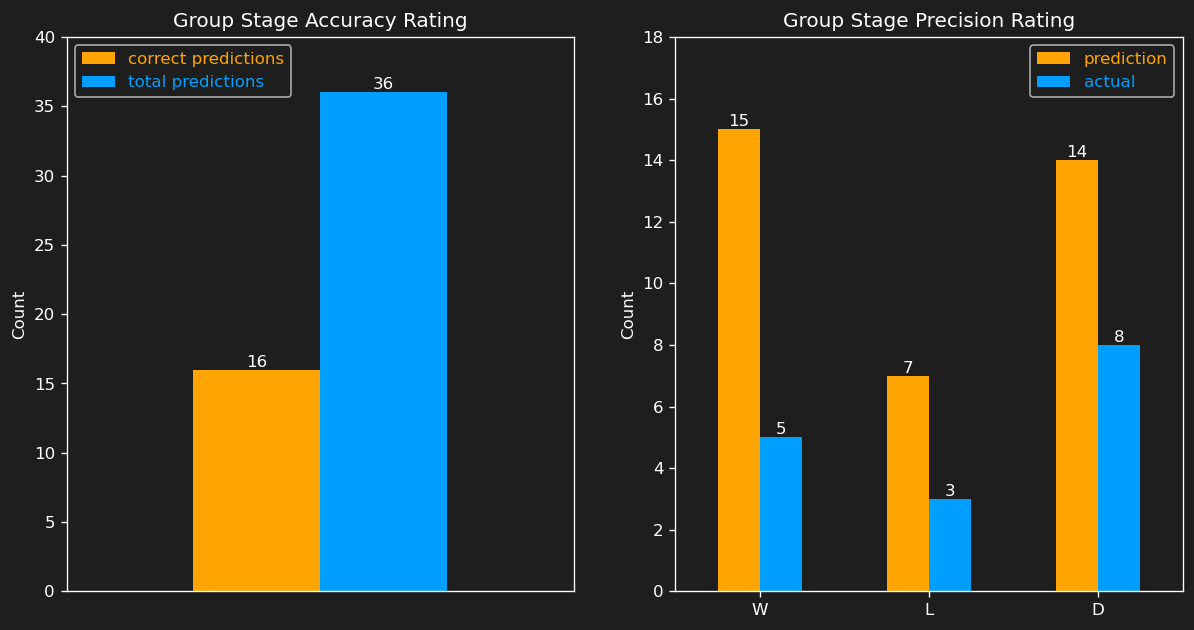

In [234]:
import matplotlib.pyplot as plt 
import numpy as np 

nrows = 1
ncols = 2
f_width = 12
f_height = 6
fig, axes = plt.subplots(nrows, ncols, figsize=(f_width, f_height), dpi=120)


ac_table.plot.bar( 
    ax= axes[0],
    rot=0, 
    color=["#FFA400", "#009ffd"],

    xticks=[],
    ylim=[0,40]
)

ps_table.plot.bar(
     ax = axes[1],
     rot=0,
     color=["#FFA400", "#009ffd"],
    
     ylim=[0,18],
     yticks=np.arange(0, 22, step=2)
)

fig.patch.set_facecolor("#1e1e1e")
axes[0].set_title("Group Stage Accuracy Rating", color="white")
axes[1].set_title("Group Stage Precision Rating", color="white")

for ax in axes: 
    ax.bar_label(ax.containers[0], color="white")
    ax.bar_label(ax.containers[1], color="white")
    
    ax.set_facecolor("#1e1e1e")    
    ax.set_ylabel('Count', color='white')
    ax.tick_params(colors='white')
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.legend(facecolor="#1e1e1e", labelcolor="linecolor")

plt.savefig("./graphics/e_performance")
plt.show()